# Spleen segmentation inference with Triton and Monai


## Setup environment

In [1]:
import matplotlib.pyplot as plt

import tritonclient.utils as tu
import tritonclient.http as httpclient

import numpy as np
import os
from uuid import uuid4
from monai.transforms import LoadImage
import tempfile
from monai.apps import download_and_extract

/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)


/tmp/tmp161vuacq


## Download dataset

Downloads and extracts the dataset.
The dataset comes from http://medicaldecathlon.com/.

In [3]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [06:25, 4.18MB/s]                                                                               

2022-02-22 03:51:52,433 - INFO - Downloaded: /tmp/tmp161vuacq/Task09_Spleen.tar


2022-02-22 03:51:54,898 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-02-22 03:51:54,901 - INFO - Writing into directory: /tmp/tmp161vuacq.


In [4]:
infer_file = os.path.join(data_dir, "imagesTs/spleen_7.nii.gz")
nifti_files = [infer_file]
print(len(nifti_files))

1


## Execute a typical inference process

(1, 512, 512, 114)


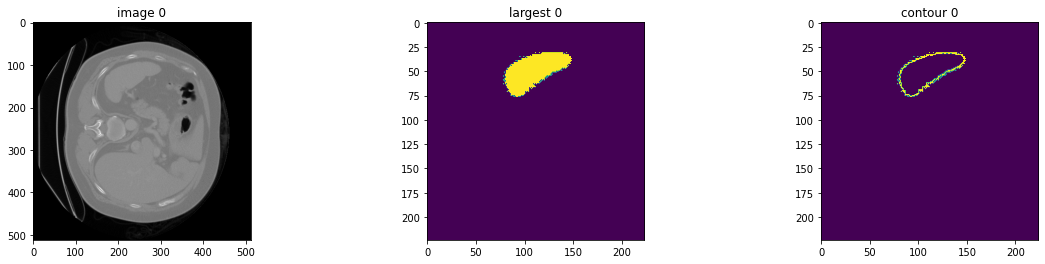

In [6]:
model_name = "spleen_seg"
with httpclient.InferenceServerClient("localhost:18100") as client:
    image_bytes = b''
    for i, nifti_file in enumerate(nifti_files):
        image = LoadImage(reader="NibabelReader", image_only=True, dtype=np.float32)(nifti_file)
        input0_data = np.expand_dims(image.array, axis=0)
        print(input0_data.shape)
        inputs = [
            httpclient.InferInput("INPUT0", input0_data.shape, tu.np_to_triton_dtype(input0_data.dtype)),
        ]
        inputs[0].set_data_from_numpy(input0_data)
        outputs = [
            httpclient.InferRequestedOutput("MASK"),
            httpclient.InferRequestedOutput("CONTOUR")
        ]
        response = client.infer(model_name,
                                inputs,
                                request_id=str(uuid4().hex),
                                outputs=outputs,)
        result = response.get_response()
        result = response.as_numpy("MASK")
        plt.figure("check", (20, 4))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(image[:, :, 57], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"largest {i}")
        plt.imshow(result[0, 0, :, :, 112])
        plt.subplot(1, 3, 3)
        plt.title(f"contour {i}")
        result = response.as_numpy("CONTOUR")
        plt.imshow(result[0, 0, :, :, 112])
        plt.show()